In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from Forcasting import graph, conversionSingle, rmsemape
from statsmodels.tsa.api import VARMAX

[*********************100%***********************]  2 of 2 completed
C:\Users\AB92922\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Columns in DataFrame: Index(['AAPL', 'MSFT'], dtype='object')
Len: (1006, 2)
Training Size: 805
Train data length: (805, 2)
Test data length: (201, 2)
RMSE-Testset AAPL: 0.251826471817669
MAPE-Testset AAPL: 0.2640026782563479
RMSE-Testset MSFT: 0.31427000224408685
MAPE-Testset MSFT: 0.3576626902492174


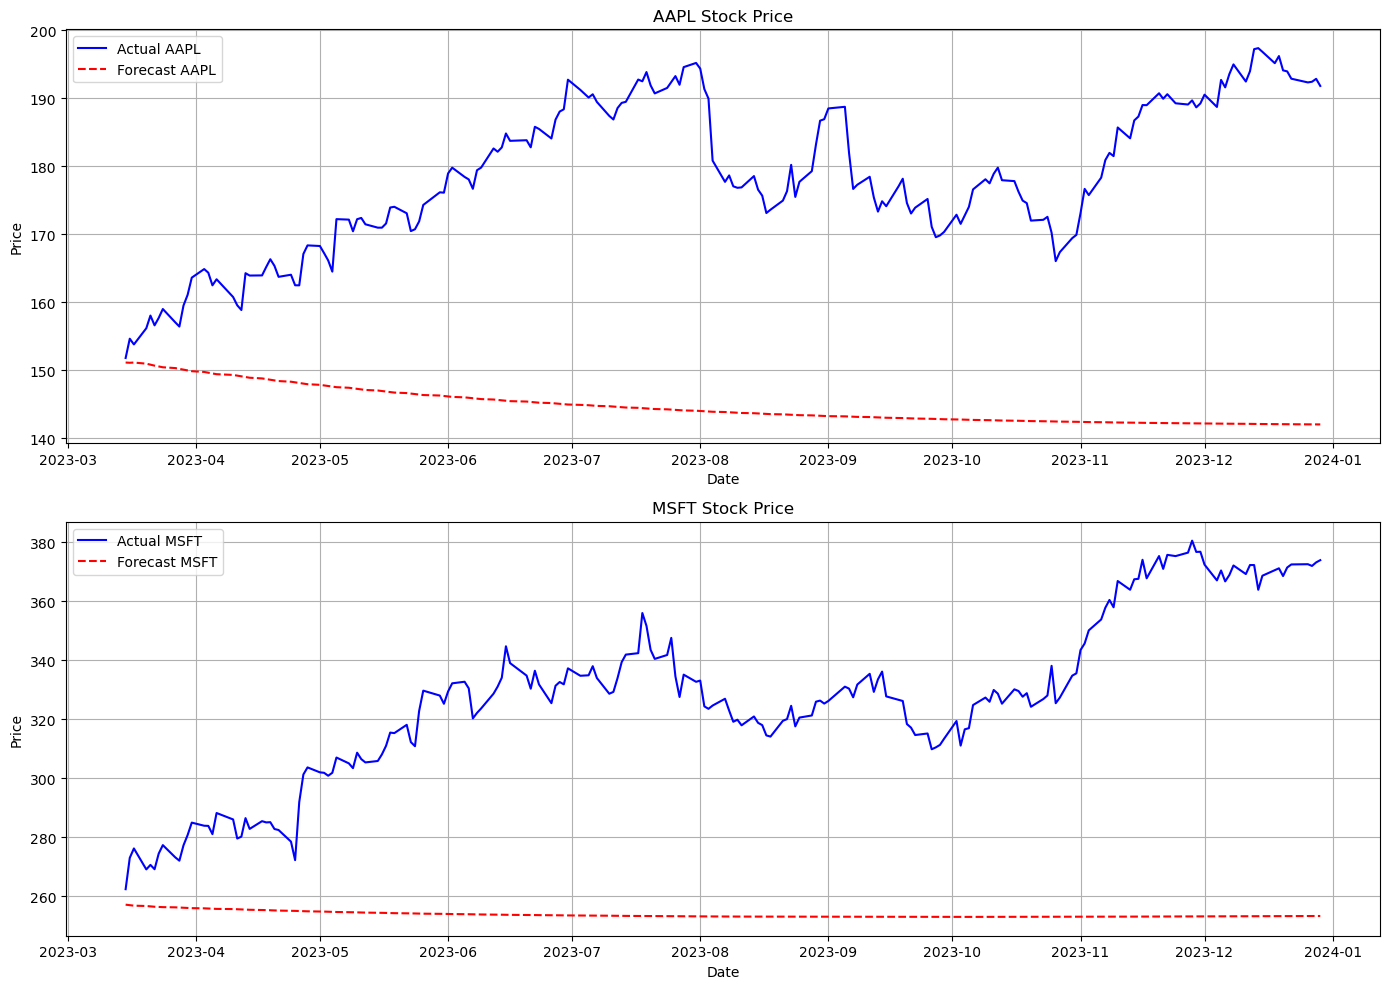

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VARMAX
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Load your data
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']
data.columns = ['AAPL', 'MSFT']  # Rename columns for consistency

# Print column names to verify
print("Columns in DataFrame:", data.columns)

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['AAPL', 'MSFT']])
data_scaled_df = pd.DataFrame(data_scaled, columns=['AAPL_Price', 'MSFT_Price'], index=data.index)

print("Len:", data_scaled.shape)

# Split data into train and test sets
training_size = round(len(data_scaled) * 0.80)
print("Training Size:", training_size)

train_data = data_scaled_df.iloc[:training_size]
test_data = data_scaled_df.iloc[training_size:]

print("Train data length:", train_data.shape)
print("Test data length:", test_data.shape)

# Fit VARMA model using VARMAX
model = VARMAX(train_data, order=(1, 1))  # order=(p, q) for VARMA
model_fit = model.fit(disp=False)

# Predict on test set
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=['AAPL_Price', 'MSFT_Price'])

print("RMSE-Testset AAPL:", np.sqrt(((test_data['AAPL_Price'] - forecast_df['AAPL_Price'])**2).mean()))
print("MAPE-Testset AAPL:", (np.abs((test_data['AAPL_Price'] - forecast_df['AAPL_Price']) / test_data['AAPL_Price'])).mean())

print("RMSE-Testset MSFT:", np.sqrt(((test_data['MSFT_Price'] - forecast_df['MSFT_Price'])**2).mean()))
print("MAPE-Testset MSFT:", (np.abs((test_data['MSFT_Price'] - forecast_df['MSFT_Price']) / test_data['MSFT_Price'])).mean())

# Inverse transform forecast to original scale
forecast_inv = scaler.inverse_transform(forecast_df[['AAPL_Price', 'MSFT_Price']])
forecast_inv_df = pd.DataFrame(forecast_inv, columns=['AAPL', 'MSFT'], index=forecast_df.index)

# Inverse transform test data to original scale
test_data_inv = scaler.inverse_transform(test_data[['AAPL_Price', 'MSFT_Price']])
test_data_inv_df = pd.DataFrame(test_data_inv, columns=['AAPL', 'MSFT'], index=test_data.index)

# Plot actual vs forecasted values
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(test_data_inv_df.index, test_data_inv_df['AAPL'], label='Actual AAPL', color='blue')
plt.plot(forecast_inv_df.index, forecast_inv_df['AAPL'], label='Forecast AAPL', color='red', linestyle='--')
plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(test_data_inv_df.index, test_data_inv_df['MSFT'], label='Actual MSFT', color='blue')
plt.plot(forecast_inv_df.index, forecast_inv_df['MSFT'], label='Forecast MSFT', color='red', linestyle='--')
plt.title('MSFT Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save forecast to CSV
forecast_inv_df.to_csv("StockPriceForecast_VARMA.csv", index=True)
